<a href="https://colab.research.google.com/github/rasutt/Bayesian-GLM/blob/main/DARE_Final_Project_Robin's_copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DARE Final Project

## Spatio-temporal Gaussian Processes and Bayesian Optimisation for Placement of Air Quality Sensors in Sydney

### Robin Aldridge-Sutton & Paco Tseng

**This is a copy of Roman's final tutorial on this topic, with our data and code interspersed to follow along with his until it's working.**

## Background Description

We will conduct spatial temporal modelling using a Gaussian Process Model.


## 0. Prepare Environment
### Import relevant packages

In [1]:
import numpy as np # Numpy is a popular numeric computation package
import pandas as pd # Pandas is a friendly data wrangling package/library
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Setting a specific random seed, to get reproducibility
np.random.seed(100) 

## 1. Load Dataset

In [2]:
# Load dataset
df_temp = pd.read_csv('temp_data.csv')

print(df_temp)

      station_id                station_name  ...  date_decimal  mean_max_temp
0          66037          Sydney Airport AMO  ...   1939.291667           22.6
1          66037          Sydney Airport AMO  ...   1939.375000           20.6
2          66037          Sydney Airport AMO  ...   1939.458333           17.5
3          66037          Sydney Airport AMO  ...   1939.541667           15.3
4          66037          Sydney Airport AMO  ...   1939.625000           18.5
...          ...                         ...  ...           ...            ...
3059       68257  Campbelltown (Mount Annan)  ...   2020.791667           25.2
3060       68257  Campbelltown (Mount Annan)  ...   2020.875000           27.7
3061       68257  Campbelltown (Mount Annan)  ...   2020.958333           26.9
3062       68257  Campbelltown (Mount Annan)  ...   2021.041667           29.3
3063       68257  Campbelltown (Mount Annan)  ...   2021.125000           27.2

[3064 rows x 12 columns]


In [6]:
# Load dataset
aq_df = pd.read_csv('Daily avg air quality data 21-04-2020 to 2021 with site data.csv')
print(aq_df)

                    Site  Lat.South  ...  NO2.24h.pphm  OZONE.24h.pphm.1
0                 ALBURY  -36.05183  ...           NaN               NaN
1                  BARGO  -34.30630  ...           1.0               1.3
2               BATHURST  -33.40192  ...           NaN               NaN
3             BERESFIELD  -32.79679  ...           1.0               1.0
4      BRADFIELD HIGHWAY  -33.84343  ...           2.7               0.5
...                  ...        ...  ...           ...               ...
16099           TAMWORTH  -31.10991  ...           NaN               NaN
16100           VINEYARD  -33.65623  ...           NaN               NaN
16101           WALLSEND  -32.89439  ...           NaN               NaN
16102         WOLLONGONG  -34.41706  ...           NaN               NaN
16103              WYONG  -33.27897  ...           NaN               NaN

[16104 rows x 11 columns]


### Plot over time for one location

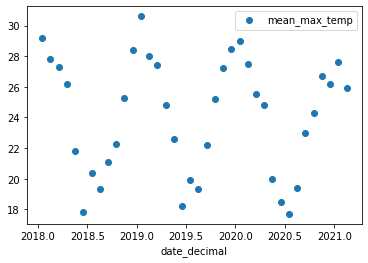

In [ ]:
sydney_airport_df = df_temp[(df_temp['station_name']=='Sydney Airport AMO') & (df_temp['year']>2017)]

#Plot the data for one stations
sydney_airport_df.plot('date_decimal', 'mean_max_temp', style=['o'])

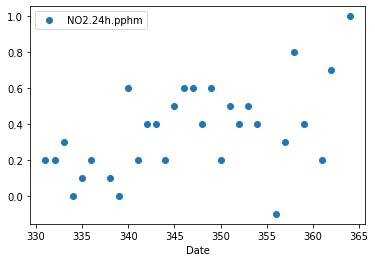

In [14]:
bargo_df = aq_df[(aq_df['Site'] == 'BARGO') & (aq_df['Date'] > 330)]

#Plot the data for one stations
bargo_df.plot('Date', 'NO2.24h.pphm', style=['o'])

### Plot over space for one timepoint

      station_id  ... mean_max_temp
933        66037  ...          30.1
1564       66137  ...          31.8
1868       66194  ...          30.3
2094       66196  ...          26.5
2208       66212  ...          31.6
2555       67113  ...          33.9
2842       68228  ...          26.9
3014       68257  ...          32.4

[8 rows x 12 columns]


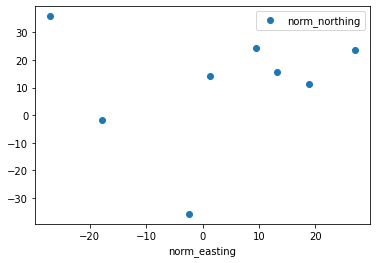

In [ ]:
#Plot the spatial locations for all stations
jan_2017_df = df_temp[(df_temp['year'] == 2017) & (df_temp['month'] == 1)]
print(jan_2017_df)

jan_2017_df.plot('norm_easting','norm_northing',style=['o'])

                    Site  Lat.South  ...  NO2.24h.pphm  OZONE.24h.pphm.1
14476             ALBURY  -36.05183  ...           NaN               1.7
14477              BARGO  -34.30630  ...           0.4               1.3
14478           BATHURST  -33.40192  ...           NaN               1.4
14479         BERESFIELD  -32.79679  ...           0.6               0.3
14480  BRADFIELD HIGHWAY  -33.84343  ...           2.1               0.4
14481          BRINGELLY  -33.91765  ...           0.3               1.1
14482             CAMDEN  -34.04170  ...           0.5               0.9
14483  CAMPBELLTOWN WEST  -34.06667  ...           0.6               0.9
14484         CARRINGTON  -32.90972  ...           0.5               NaN
14485           CHULLORA  -33.89157  ...           1.0               0.7
14486      COFFS HARBOUR  -30.29831  ...           0.3               1.3
14487   COOK AND PHILLIP  -33.87247  ...           1.2               0.5
14488           EARLWOOD  -33.91618  ...           

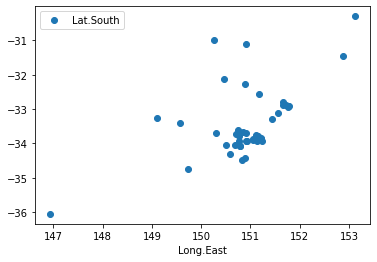

In [15]:
# Plot the spatial locations for all sites
date_330_df = aq_df[(aq_df['Date'] == 330)]
print(date_330_df)

date_330_df.plot('Long.East','Lat.South', style=['o'])

## 2. Resuse and modify existing Gaussian Process Code

The main differences with the previous tutorials are that:

1. The data is spatial temporal format – assuming that the first two columns of $x$ are $s$ and the third column of $x$ is $t$.



In [ ]:
class GP:
    def __init__(self,cov_function_name, x_train, y_train, hyper_params, sigma_n):
        self.verbose = True
        self.cov_function_name = cov_function_name
        self.x_train = x_train
        self.y_train = y_train
        self.hyper_params = hyper_params #params[0] is signal variance, params[1] is lengthscale
        self.K = self.cov_func(self.x_train,self.x_train)
        self.sigma_n = sigma_n
        self.K_inv = np.linalg.pinv(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2))
        
    def predict(self,x_star):
        k_star = self.cov_func(self.x_train,x_star)
        f_mean = np.transpose(k_star) @ self.K_inv @ self.y_train
        f_std = self.cov_func(x_star, x_star) - np.transpose(k_star) @ self.K_inv @ k_star
        f_std = np.sqrt(np.diag(f_std))[:,np.newaxis]
        return [f_mean,f_std]
    
    def set_training_data(self,x,y):
        self.x_train = x
        self.y_train = y
        self.K = self.cov_func(self.x_train,self.x_train)
        self.sigma_n = sigma_n
        self.K_inv = np.linalg.pinv(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2))

    def cov_func(self,x_1,x_2):
        if self.cov_function_name == "Squared Exponential":
            x_1_sq = np.sum(np.square(x_1),1)
            x_2_sq = np.sum(np.square(x_2),1)
            d = -2.*np.dot(x_1, x_2.T) + (x_1_sq[:,None] + x_2_sq[None,:])
            K = self.hyper_params[0]**2 * np.exp(-0.5 * d/self.hyper_params[1]**2)
        if self.cov_function_name == "Spatial Temporal":
            s_1 = x_1[:,0:2]
            s_2 = x_2[:,0:2]
            s_1_sq = np.sum(np.square(s_1),1)
            s_2_sq = np.sum(np.square(s_2),1)
            d = -2.*np.dot(s_1, s_2.T) + (s_1_sq[:,None] + s_2_sq[None,:])
            K_s = self.hyper_params[0]**2 * np.exp(-0.5 * d/self.hyper_params[1]**2)
            
            t_1 = x_1[:,2][:,np.newaxis]
            t_2 = x_2[:,2][:,np.newaxis]
            t_1_sq = np.sum(np.square(t_1),1)
            t_2_sq = np.sum(np.square(t_2),1)
            d_t = -2.*np.dot(t_1, t_2.T) + (t_1_sq[:,None] + t_2_sq[None,:])
            P = 1
            K_t = self.hyper_params[2]**2 * np.exp(-2 * np.sin(np.pi*(np.sqrt(d_t)/P))**2/self.hyper_params[3]**2)
            
            K = np.multiply(K_s,K_t)
        return K
    
    def set_hyper_params(self, hyper_params, sigma_n):
        self.hyper_params = hyper_params
        self.K = self.cov_func(self.x_train,self.x_train)
        self.sigma_n = sigma_n
        self.K_inv = np.linalg.pinv(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2))
        
    def log_marginal_likelihood(self):
        lml1 = -.5*(np.transpose(self.y_train) @ self.K_inv @ self.y_train)
        #! Very important - Last tutorial the log marginal likelihood term was missing and np.log for the determinant.
        #! Results in an over estimation of the noise
        lml2 = -.5*np.log(np.linalg.det(self.K+np.eye(self.K.shape[0])*(self.sigma_n**2)))
        lml3 = -.5*self.x_train.shape[0]*np.log(2*np.pi)
        return lml1+lml2+lml3
    
    def fit(self):
        print("GP Optimising Hyper-parameters")
        from scipy.optimize import minimize

        def eval_params(params, gp):
            params = np.exp(params)
            gp.set_hyper_params(params[:-1],params[len(params)-1])
            nlml = -gp.log_marginal_likelihood()
            if gp.verbose:
                print(str(params)+str(nlml))
            return nlml

        x0 = np.array([np.log(2), np.log(12),np.log(3),np.log(0.5),np.log(0.3)])
        res = minimize(eval_params, x0, method='nelder-mead', args=(self),
                       options={'xatol': 1e-10, 'disp': True})
        if res.success:
            print("Optimisation results: ")
            optimal_params = np.exp(res.x)
            print(optimal_params)
            print("LML")
            print(self.log_marginal_likelihood())
            self.set_hyper_params([optimal_params[0],optimal_params[1],optimal_params[2],optimal_params[3]],optimal_params[4])
        else:
            print("Error when fitting GP.")

## 3. Test temporal regression

Train the GP with data from only one station, "Sydney Airport AMO" from 2017 onwards.

(50, 3)


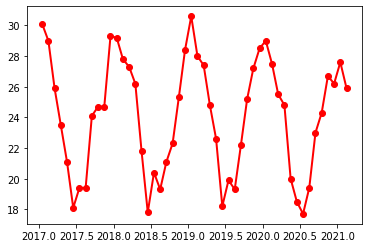

In [ ]:
#Test time regression
sydney_airport_df = df_temp[(df_temp['station_name']=='Sydney Airport AMO') & (df_temp['date_decimal']>2017)]

X = sydney_airport_df[['norm_easting','norm_northing','date_decimal']].values
y = sydney_airport_df['mean_max_temp'].values[:,np.newaxis]

print(X.shape)

plt.plot(X[:,2], y, 'r-o', lw=2, label='Noise-free objective')

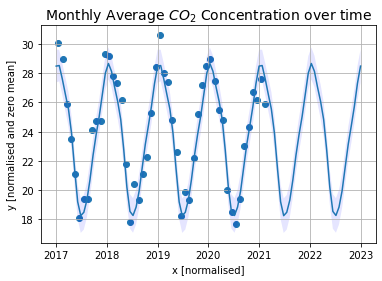

In [ ]:
s_signal_variance = 1
s_lengthscale = 0.3
t_signal_variance = 3
t_lengthscale = 0.8
sigma_n = 1.5

gp = GP("Spatial Temporal", X, y, [s_signal_variance,s_lengthscale,t_signal_variance,t_lengthscale], sigma_n)

x_star_s = [X[0,0],X[0,1]]
x_star_s_tiled = np.tile(x_star_s, (100,1))
#print(x_star_s)
#print(x_star_s_tiled)
x_star_t = np.linspace(2017,2023,100)[:,np.newaxis]
x_star = np.concatenate((x_star_s_tiled, x_star_t), axis=1)

[f_mean,f_std] = gp.predict(x_star)

plt.scatter(X[:,2], y)
plt.fill_between(x_star_t.ravel(), (f_mean-2*f_std).ravel(), (f_mean+2*f_std).ravel(), \
                facecolor='blue', interpolate=True, alpha=0.1, label='±2*sigma of prediction')
plt.plot(x_star_t, f_mean)
plt.title('Monthly Average $CO_2$ Concentration over time', fontsize=14)
plt.xlabel('x [normalised]')
plt.ylabel('y [normalised and zero mean]')
plt.grid()


## 4. Test Spatial Regression

[[ 1.88763220e+01  1.12050895e+01  2.01704167e+03]
 [ 1.25069000e+00  1.42025705e+01  2.01704167e+03]
 [ 1.32493920e+01  1.55405085e+01  2.01704167e+03]
 [ 2.69873690e+01  2.35483705e+01  2.01704167e+03]
 [ 9.38419000e+00  2.43436725e+01  2.01704167e+03]
 [-2.69873690e+01  3.57979755e+01  2.01704167e+03]
 [-2.35963800e+00 -3.57979755e+01  2.01704167e+03]
 [-1.78275700e+01 -1.72680650e+00  2.01704167e+03]]
(8, 3)


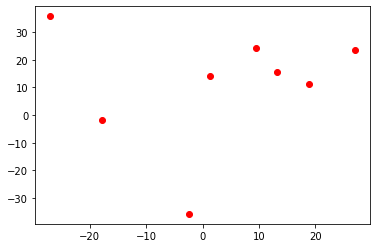

In [ ]:
#Test space regression
space_df = df_temp[(df_temp['year'] == 2017) & (df_temp['month'] == 1)]

X = space_df[['norm_easting','norm_northing','date_decimal']].values
y = space_df['mean_max_temp'].values[:,np.newaxis]
y_mean = np.mean(y)
y = y - y_mean
print(X)
print(X.shape)

plt.plot(X[:,0], X[:,1], 'ro', lw=2, label='Noise-free objective')

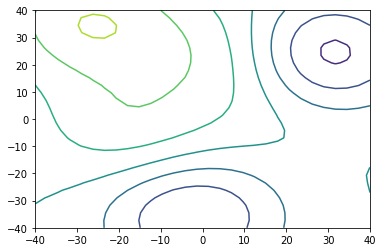

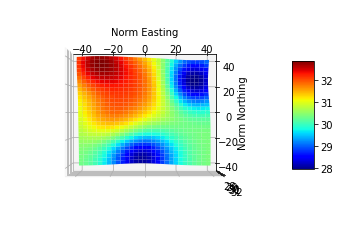

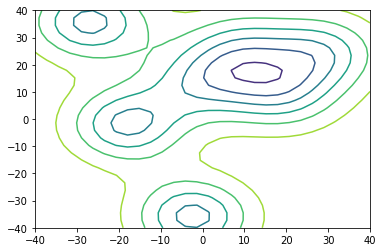

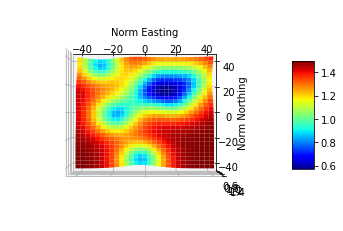

In [ ]:
s_signal_variance = 0.5
s_lengthscale = 15
t_signal_variance = 3
t_lengthscale = 0.5
sigma_n = 1

gp = GP("Spatial Temporal", X, y, [s_signal_variance,s_lengthscale,t_signal_variance,t_lengthscale], sigma_n)

n_samples_per_dim = 30
x_star_s_easting = np.linspace(-40,40,n_samples_per_dim)[:,np.newaxis]
x_star_s_northing = np.linspace(-40,40,n_samples_per_dim)[:,np.newaxis]
x_star_s_easting, x_star_s_northing = np.meshgrid(x_star_s_easting, x_star_s_northing)
x_star = np.zeros((n_samples_per_dim**2,3))
idx = 0
for i in range(n_samples_per_dim):
    for j in range(n_samples_per_dim):
        x_star[idx,0] = x_star_s_easting[i,j]
        x_star[idx,1] = x_star_s_northing[i,j]
        x_star[idx,2] = 2.01704167e+03
        idx += 1

[f_mean,f_std] = gp.predict(x_star)
z = np.reshape(f_mean+y_mean,(n_samples_per_dim,n_samples_per_dim))

plt.contour(x_star_s_easting,x_star_s_northing,z)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
h = ax.plot_surface(x_star_s_easting,x_star_s_northing,z, cmap='jet',antialiased=True)
ax.set_xlabel('Norm Easting')
ax.view_init(azim=-90, elev=90)
ax.set_ylabel('Norm Northing')
# Add a color bar which maps values to colors.
fig.colorbar(h, shrink=0.5, aspect=5)
plt.show()

z_std = np.reshape(f_std,(n_samples_per_dim,n_samples_per_dim))

plt.contour(x_star_s_easting,x_star_s_northing,z_std)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
h = ax.plot_surface(x_star_s_easting,x_star_s_northing,z_std, cmap='jet',antialiased=True)
ax.set_xlabel('Norm Easting')
ax.view_init(azim=-90, elev=90)
ax.set_ylabel('Norm Northing')
# Add a color bar which maps values to colors.
fig.colorbar(h, shrink=0.5, aspect=5)
plt.show()


## 5. Spatial Temporal Regression

[[ 1.88763220e+01  1.12050895e+01  2.01704167e+03]
 [ 1.88763220e+01  1.12050895e+01  2.01712500e+03]
 [ 1.88763220e+01  1.12050895e+01  2.01720833e+03]
 ...
 [-1.78275700e+01 -1.72680650e+00  2.02095833e+03]
 [-1.78275700e+01 -1.72680650e+00  2.02104167e+03]
 [-1.78275700e+01 -1.72680650e+00  2.02112500e+03]]
(441, 3)


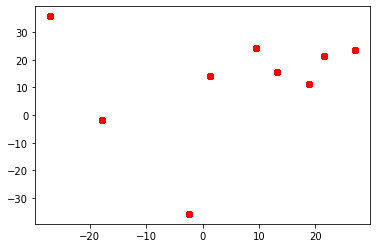

In [ ]:
# Spatial Temporal prediction

#Test space regression
space_time_df = df_temp[(df_temp['date_decimal'] > 2017)]

X = space_time_df[['norm_easting','norm_northing','date_decimal']].values
y = space_time_df['mean_max_temp'].values[:,np.newaxis]
y_mean = np.mean(y)
y = y - y_mean
print(X)
print(X.shape)

plt.plot(X[:,0], X[:,1], 'ro', lw=2, label='Noise-free objective')

In [ ]:
s_signal_variance = 0.5
s_lengthscale = 12
t_signal_variance = 3
t_lengthscale = 0.5
sigma_n = 1

gp = GP("Spatial Temporal", X, y, [s_signal_variance,s_lengthscale,t_signal_variance,t_lengthscale], sigma_n)
gp.fit()

GP Optimising Hyper-parameters
[ 2.  12.   3.   0.5  0.3][[2692.36395284]]
[ 2.07052985 12.          3.          0.5         0.3       ][[2695.23185217]]
[ 2.        13.5875235  3.         0.5        0.3      ][[2686.20365377]]
[ 2.         12.          3.16940193  0.5         0.3       ][[2696.93626764]]
[ 2.         12.          3.          0.48296816  0.3       ][[2695.66599883]]
[ 2.         12.          3.          0.5         0.28247324][[2988.70331323]]
[ 2.02791896 12.6114456   3.06664624  0.49311635  0.31861425][[2433.61003392]]
[ 2.04202425 12.92875434  3.10052254  0.48971015  0.33838346][[2205.84660179]]
[ 2.04485706 12.99316776  2.87733645  0.48903174  0.31480122][[2477.92435538]]
[ 2.06308034 13.41308158  2.98947184  0.50881038  0.3209242 ][[2397.75153575]]
[ 1.9899332  14.02385762  2.98527093  0.49492437  0.32969696][[2291.19892775]]
[ 2.05595402 14.92595036  2.97939957  0.49290858  0.34238318][[2155.2119609]]
[ 2.08451536 16.6464782   2.96915246  0.48940068  0.36576994][

/usr/local/lib/python3.7/dist-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


[ 2.39446457 53.73758903  2.9422399   0.36707064  1.85193581][[inf]]
[ 2.55514827 46.83032581  2.97128854  0.3901076   1.66447677][[846.62076151]]
[ 2.54675142 62.18989876  2.88610802  0.36501443  1.92498333][[inf]]
[ 2.28627662 25.70708358  3.06398099  0.43268821  0.81836553][[890.89890482]]
[ 2.50452887 45.51024099  3.10245783  0.35515331  1.97050217][[inf]]
[ 2.31499572 29.93667183  2.98855533  0.43082145  0.86413502][[865.80409216]]
[ 2.48269904 48.98745966  2.95894133  0.37648486  1.61559735][[838.61635282]]
[ 2.52146076 51.22556683  3.02155943  0.35826578  1.96516703][[inf]]
[ 2.36497034 34.23925691  2.99677241  0.41140951  1.0611727 ][[825.03721703]]
[ 2.47873305 65.70277394  3.16169696  0.37905906  2.00666669][[inf]]
[ 2.38744848 32.81986649  2.95994629  0.40085125  1.10232139][[825.463143]]
[ 2.22598843 31.69238258  3.07644656  0.40115975  0.92298703][[848.90705686]]
[ 2.46855499 42.47507036  2.99723617  0.39284176  1.43633983][[827.15742709]]
[ 2.28571682 28.61652045  3.10521

(50, 3)


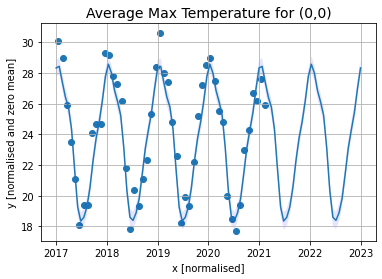

In [ ]:
sydney_airport_df = df_temp[(df_temp['station_name']=='Sydney Airport AMO') & (df_temp['date_decimal']>2017)]

X = sydney_airport_df[['norm_easting','norm_northing','date_decimal']].values
y = sydney_airport_df['mean_max_temp'].values[:,np.newaxis]
y = y-y_mean

print(X.shape)

x_star_s = [X[0,0],X[0,1]]
x_star_s_tiled = np.tile(x_star_s, (100,1))
#print(x_star_s)
#print(x_star_s_tiled)
x_star_t = np.linspace(2017,2023,100)[:,np.newaxis]
x_star = np.concatenate((x_star_s_tiled, x_star_t), axis=1)

[f_mean,f_std] = gp.predict(x_star)

f_mean = f_mean+y_mean

plt.scatter(X[:,2], y + y_mean)
plt.fill_between(x_star_t.ravel(), (f_mean-2*f_std).ravel(), (f_mean+2*f_std).ravel(), \
                facecolor='blue', interpolate=True, alpha=0.1, label='±2*sigma of prediction')
plt.plot(x_star_t, f_mean)
plt.title('Average Max Temperature for (0,0)', fontsize=14)
plt.xlabel('x [normalised]')
plt.ylabel('y [normalised and zero mean]')
plt.grid()

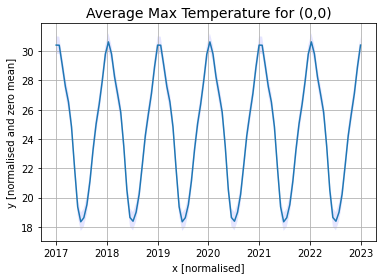

In [ ]:
x_star_s = [0,0]
x_star_s_tiled = np.tile(x_star_s, (100,1))
#print(x_star_s)
#print(x_star_s_tiled)
x_star_t = np.linspace(2017,2023,100)[:,np.newaxis]
x_star = np.concatenate((x_star_s_tiled, x_star_t), axis=1)

[f_mean,f_std] = gp.predict(x_star)

f_mean = f_mean+y_mean

plt.fill_between(x_star_t.ravel(), (f_mean-2*f_std).ravel(), (f_mean+2*f_std).ravel(), \
                facecolor='blue', interpolate=True, alpha=0.1, label='±2*sigma of prediction')
plt.plot(x_star_t, f_mean)
plt.title('Average Max Temperature for (0,0)', fontsize=14)
plt.xlabel('x [normalised]')
plt.ylabel('y [normalised and zero mean]')
plt.grid()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


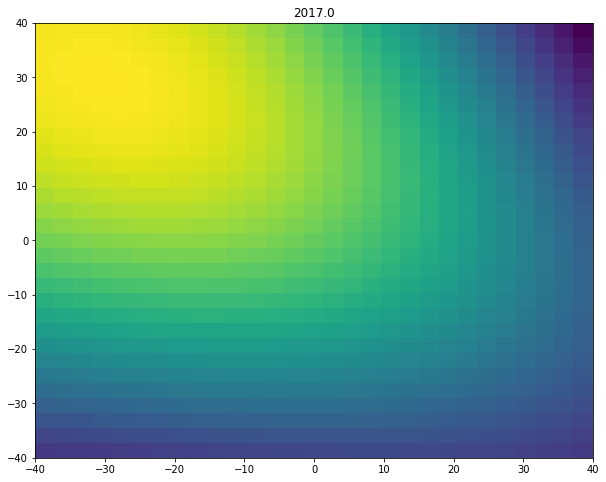

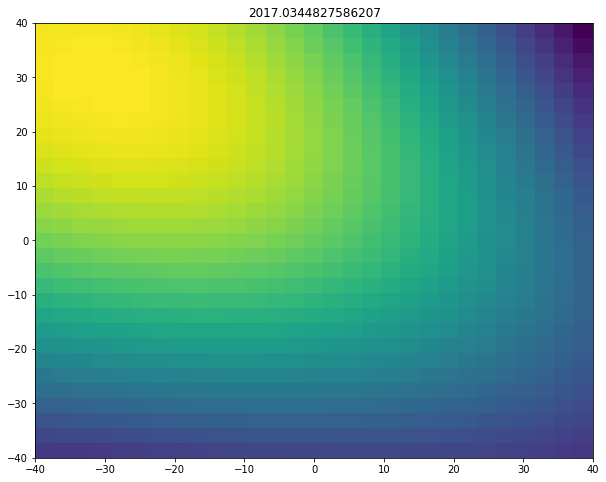

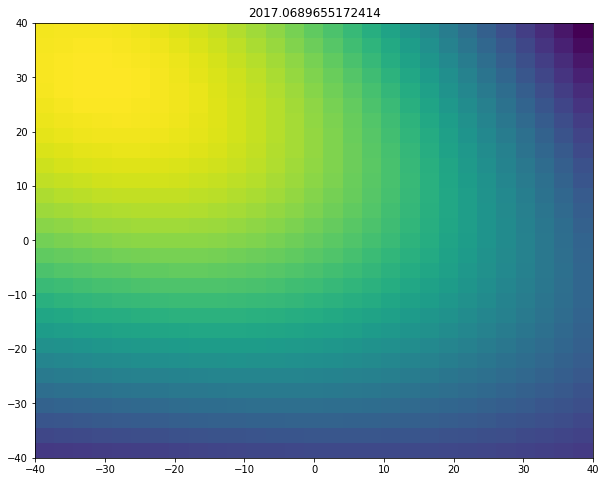

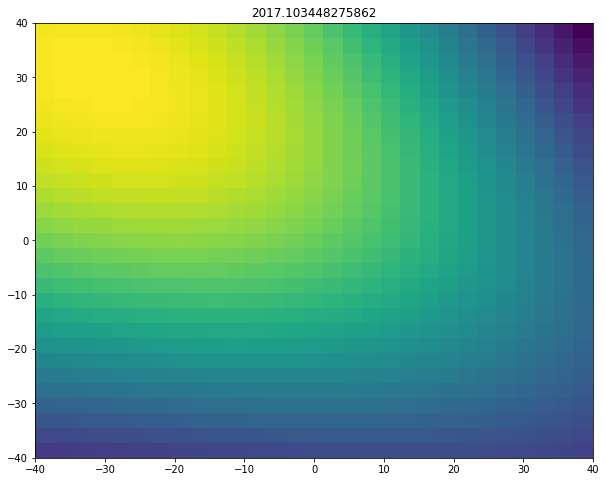

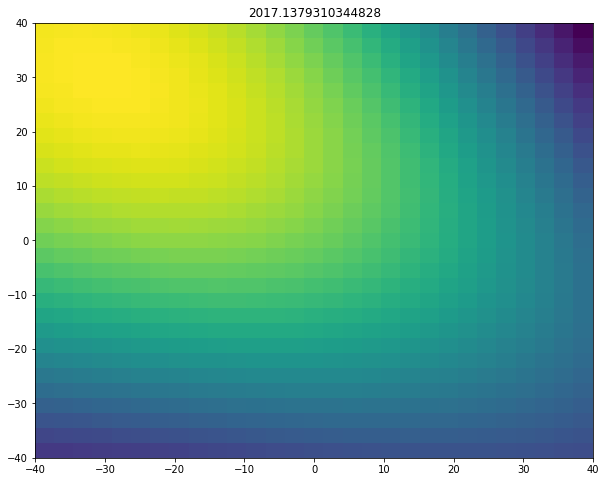

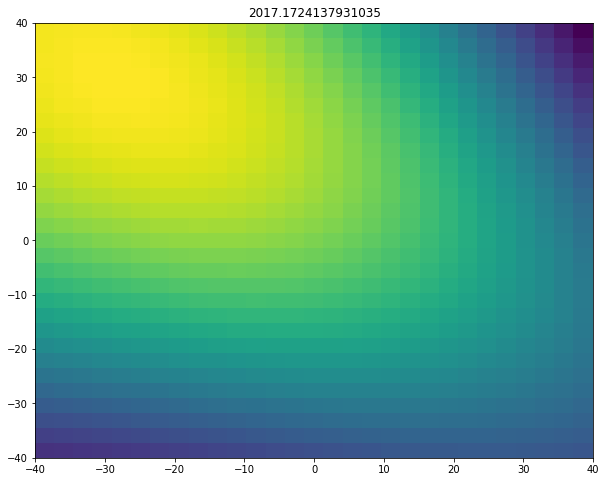

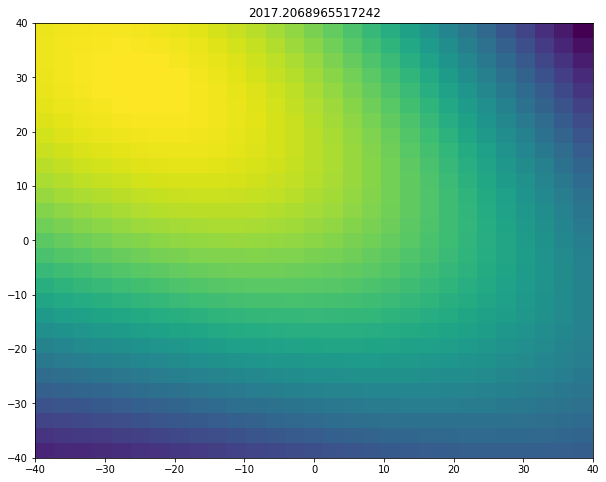

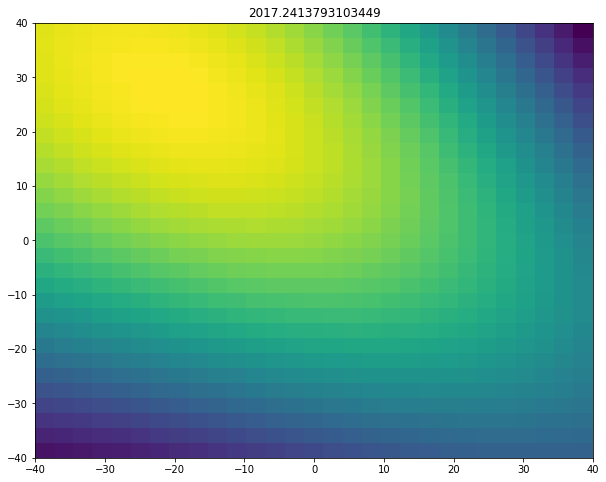

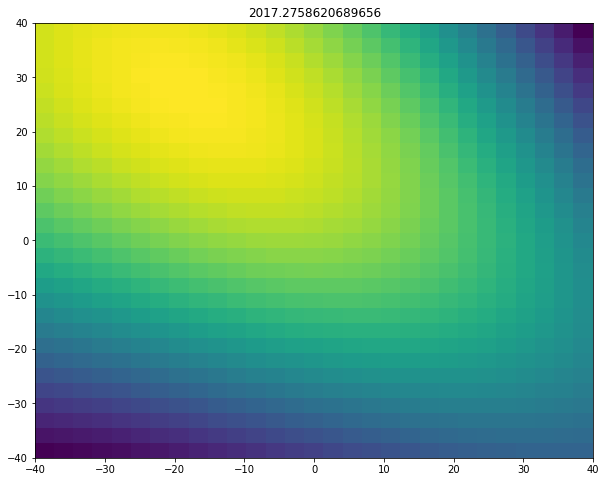

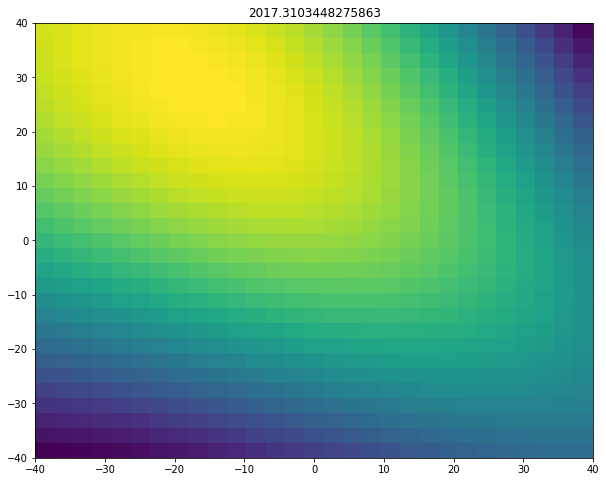

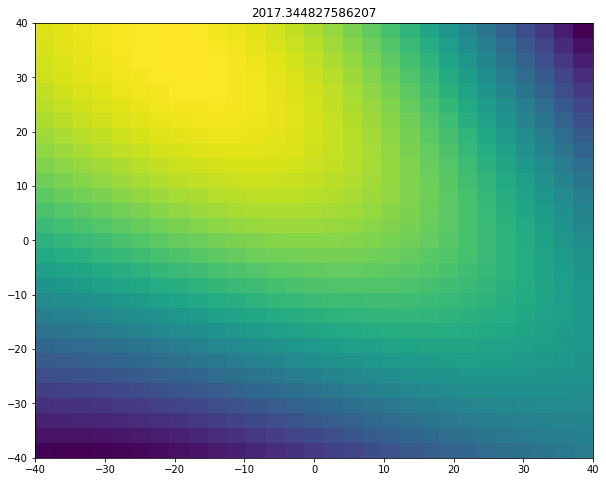

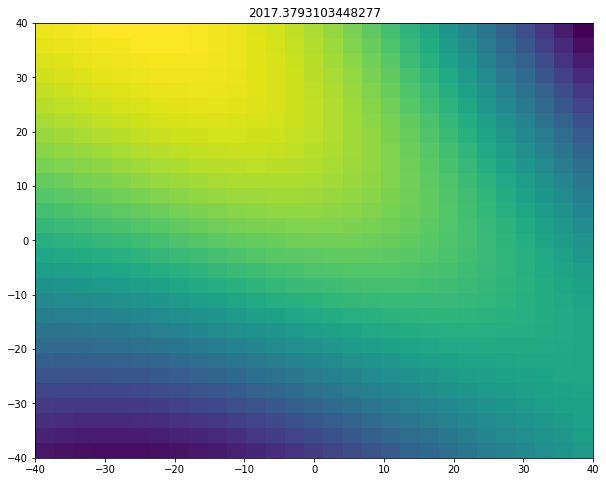

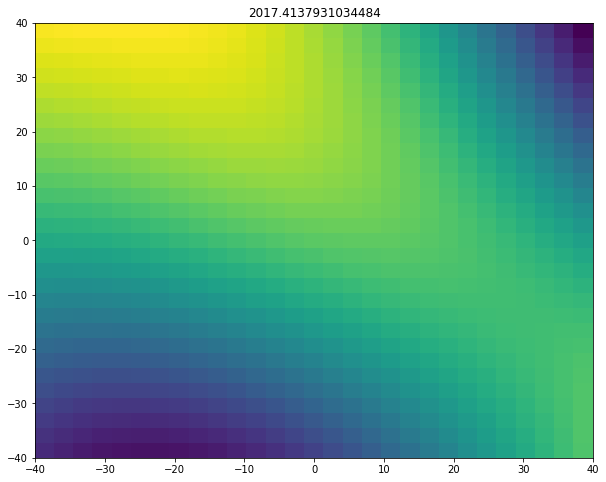

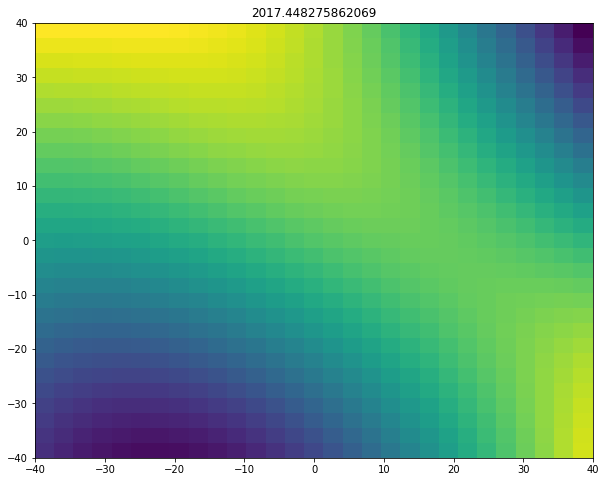

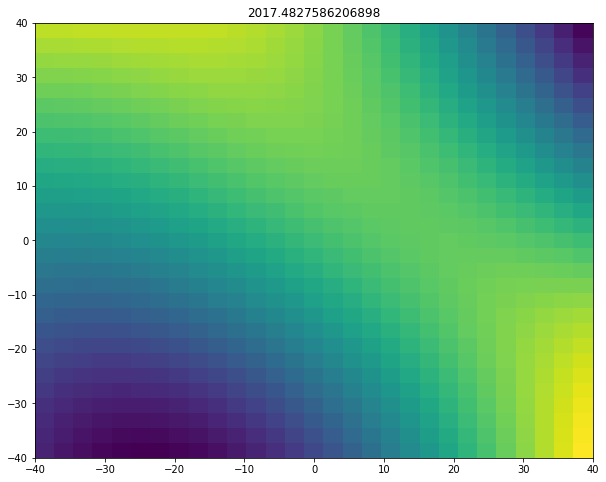

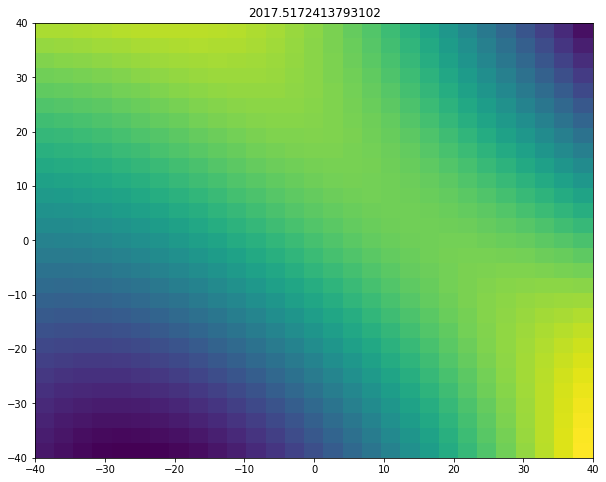

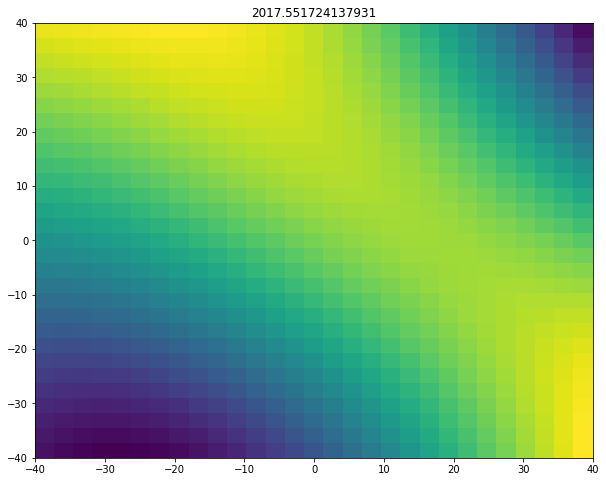

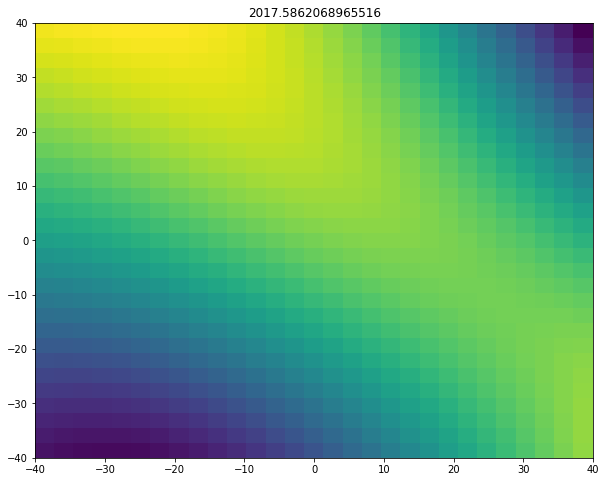

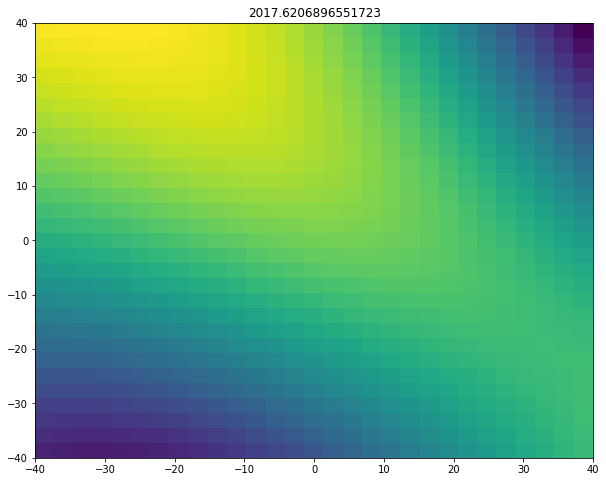

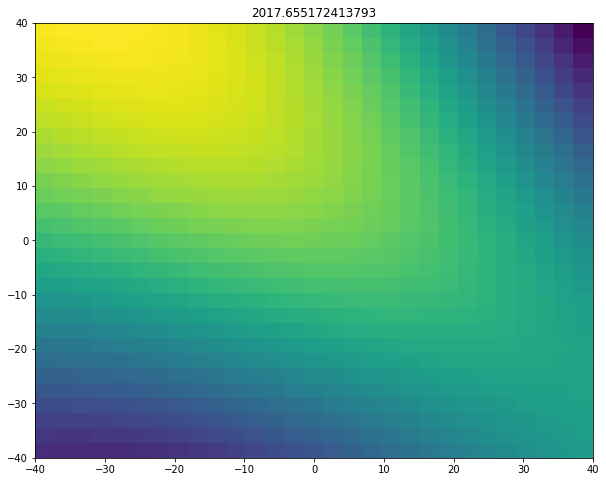

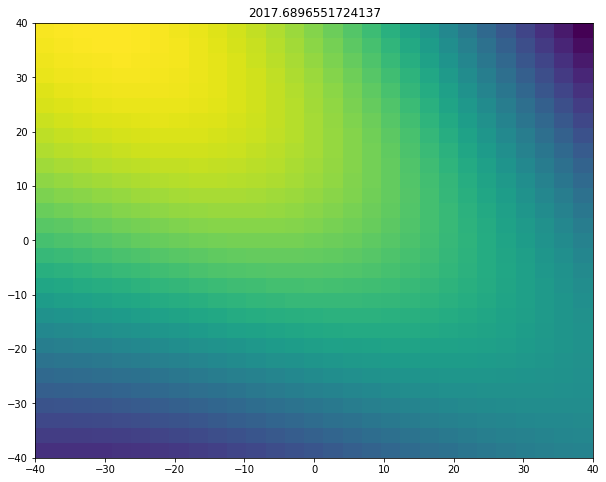

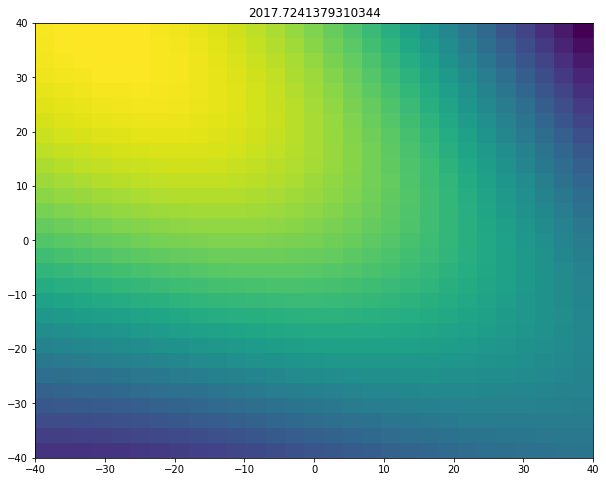

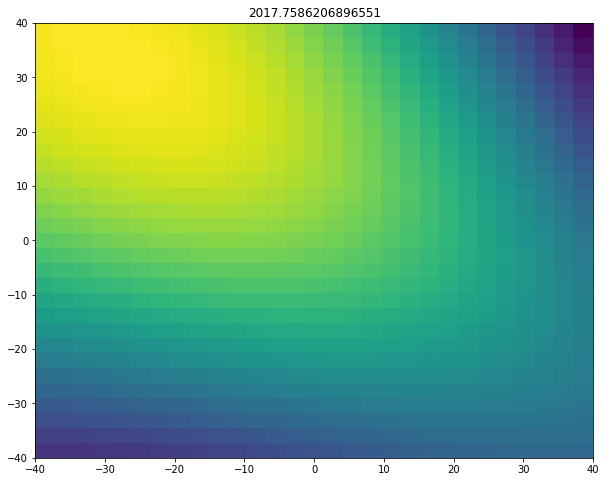

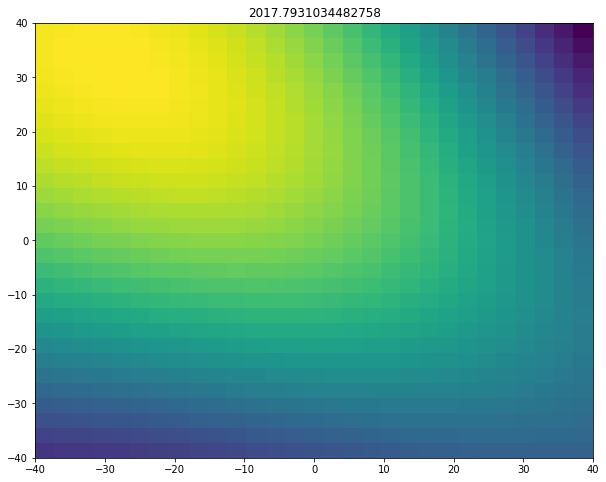

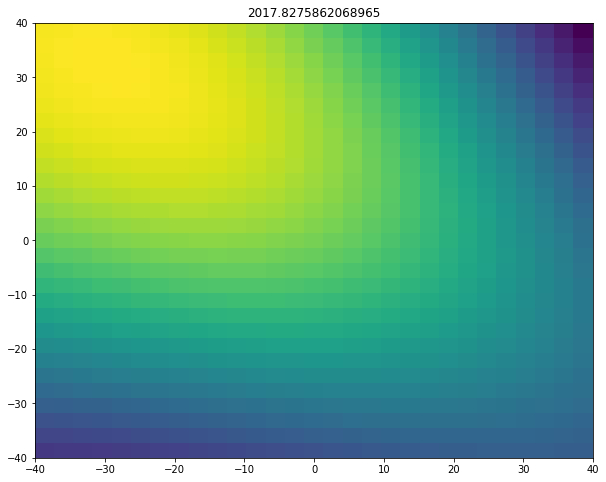

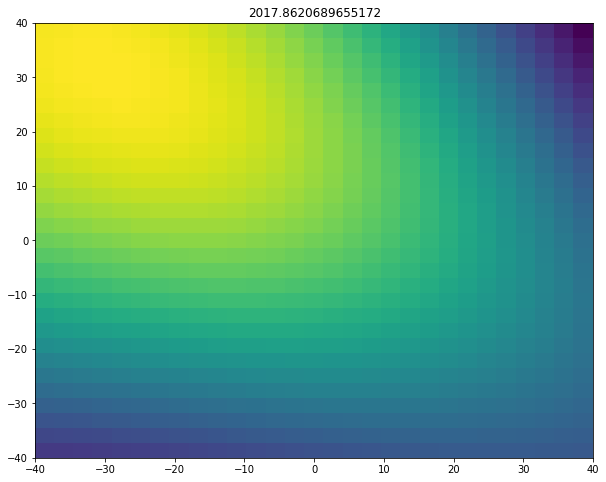

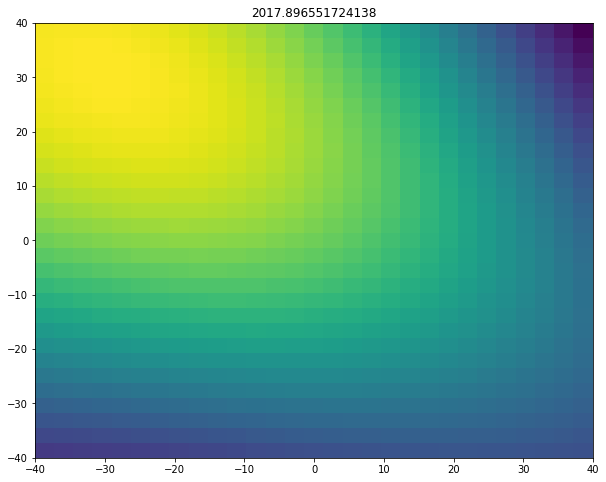

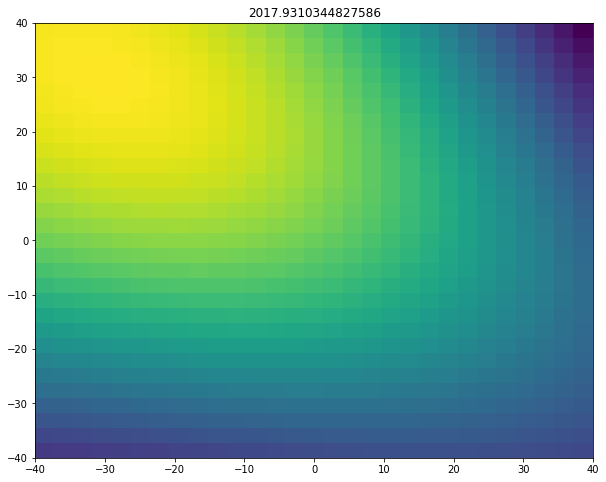

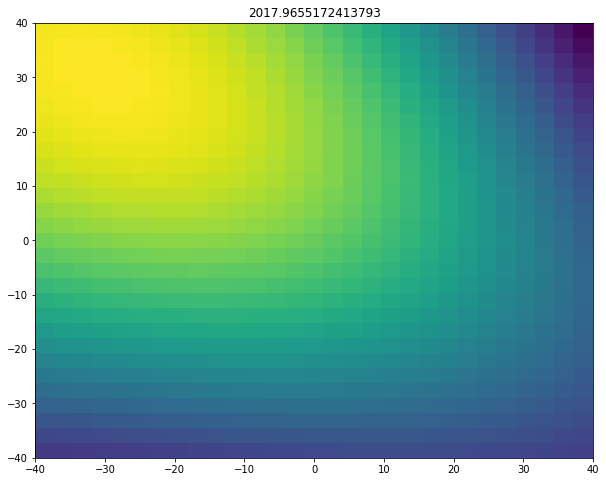

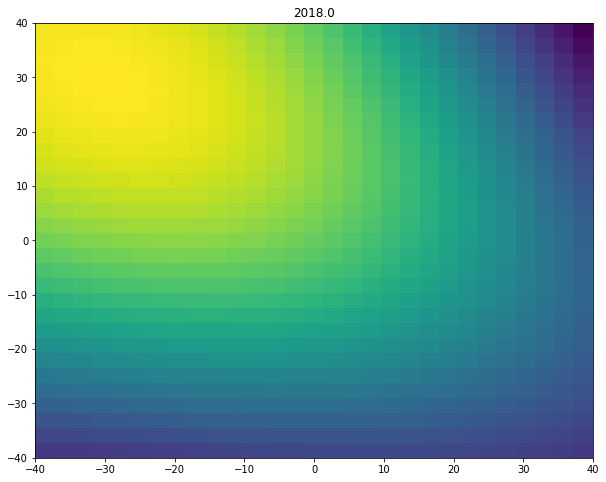

In [ ]:
x_star_t = np.linspace(2017,2018,30)[:,np.newaxis]

img_idx = 0
for t in x_star_t:
    n_samples_per_dim = 30
    x_star_s_easting = np.linspace(-40,40,n_samples_per_dim)[:,np.newaxis]
    x_star_s_northing = np.linspace(-40,40,n_samples_per_dim)[:,np.newaxis]
    x_star_s_easting, x_star_s_northing = np.meshgrid(x_star_s_easting, x_star_s_northing)
    x_star = np.zeros((n_samples_per_dim**2,3))
    idx = 0
    for i in range(n_samples_per_dim):
        for j in range(n_samples_per_dim):
            x_star[idx,0] = x_star_s_easting[i,j]
            x_star[idx,1] = x_star_s_northing[i,j]
            x_star[idx,2] = t
            idx += 1

    [f_mean,f_std] = gp.predict(x_star)
    z = np.reshape(f_mean+y_mean,(n_samples_per_dim,n_samples_per_dim))
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.pcolormesh(x_star_s_easting, x_star_s_northing, z)
    ax.set_title(str(t[0]))
    plt.savefig(f'{img_idx:03d}'+'-'+str(t[0])+'.png')
    img_idx+=1
